In [1]:
# %load /p/home/jusers/langguth1/jureca/atmorep_github/atmorep/atmorep/applications/datasets/downscaling_data_loader.py
####################################################################################################
#
#  Copyright (C) 2022
#
####################################################################################################
#
#  project     : atmorep
#
#  author      : atmorep collaboration
# 
#  description :
#
#  license     :
#
####################################################################################################

import torch
import numpy as np
import zarr
import pandas as pd
import xarray as xr
from datetime import datetime
import time
import os, sys
from pathlib import Path

In [2]:
#sys.path.insert(0, "/p/project/deepacf/atmo-rep/langguth1/atmo-rep/atmorep/")
sys.path.insert(0, "/p/project/deepacf/atmo-rep/patnala1/atmorep/")
from atmorep.datasets.normalizer import normalize
from atmorep.utils.utils import tokenize, get_weights
from atmorep.applications.downscaling.utils.era5_imerg_data_aligner import lat_lon_time_range
from atmorep.utils.logger import logger

In [3]:
def math_to_geolats(lats_math):
    """
    Convert 'mathematical' latitudes as used in AtmoRep to geographical latitudes.
    Example conversions:
        Mathematical latitude: 0° -> Geographical latitude: 90°N
        Mathematical latitude: 180° -> Geographical latitude: -90°N/90°S
    :param lats_math: 1D-array with mathematical latitudes
    :return lats_geo: 1D-array with geographical latitudes
    """
    lats_geo = np.where(lats_math > 90, -lats_math + 90, np.abs(lats_math - 90.))

    return lats_geo

def geo_to_mathlats(lats_geo):
    """
    Convert geographical latitude to 'mathematical' latitudes as used in AtmoRep.
    Example conversions:
        Geographical latitude: 90°N ->  Mathematical latitude: 0°N
        Geographical latitude: -90°N -> Mathematical latitude: 180°
    :param lats_math: 1D-array with geographical latitudes
    :return lats_geo: 1D-array with mathematical latitudes
    """
    lats_math = np.where(lats_geo > 0, np.abs(lats_geo - 90), -lats_geo + 90.)
    return lats_math

def get_latlon_arr(lat_range, lon_range, res):
    lats = np.arange(lat_range[0], lat_range[1] + res/10., res)
    lons = np.arange(lon_range[0], lon_range[1] + res/10., res)

    return lats, lons

In [39]:
class MultifieldDownscalingSampler( torch.utils.data.IterableDataset):
    
    def __init__(self, input_file_path, target_file_path, input_fields,
        target_fields, years, batch_size, n_size, num_samples, downscaling_ratio,
        with_shuffle=False, with_source_idxs = True, with_target_idxs=True) :
            super(MultifieldDownscalingSampler, self).__init__()

            self.input_fields = input_fields
            self.target_fields = target_fields
            self.n_size = n_size
            self.num_samples = num_samples
            self.with_source_idxs = with_source_idxs
            self.with_target_idxs = with_target_idxs
            self.batch_size = batch_size
            self.with_shuffle = with_shuffle
            self.downscaling_ratio = downscaling_ratio
      
            assert os.path.exists(input_file_path), f"Input file path {input_file_path} does not exist"
            assert os.path.exists(target_file_path), f"Target file path {target_file_path} does not exist"

            self.era5_ds = zarr.group(input_file_path)
            self.imerg_ds = zarr.group(target_file_path)

            self.era5_res = self.era5_ds.attrs['res']
            self.imerg_res = self.imerg_ds.attrs['res']

            self.era5_lats = np.array(self.era5_ds['lats'])
            self.era5_lons = np.array(self.era5_ds['lons'])

            self.imerg_lats = np.array(self.imerg_ds['lats'])
            self.imerg_lons = np.array(self.imerg_ds['lons'])

            self.era5_num_lats = self.era5_ds['lats'].shape[0]
            self.era5_num_lons = self.era5_ds['lons'].shape[0]
            
            self.range_lat = np.array([0,-1])
            self.range_lon = np.array([0,-1])
            self.range_time = np.array([0,-1])

            if self.era5_ds.attrs['is_global']:

                self.global_indices_range = lat_lon_time_range(
                    input_file_path,
                    target_file_path
                )
                
                lat_range = self.global_indices_range['lats']
                lon_range = self.global_indices_range['lons']
                time_range = self.global_indices_range['time']

                self.range_lat = np.array([lat_range[0], lat_range[1]])
                self.range_lon = np.array([lon_range[0], lon_range[1]])

                self.range_time = np.array([
                    time_range[0],
                    time_range[1]])
            
            self.year_base = self.era5_ds['time'][self.range_time[0]].astype(datetime).year

            # self.input_normalizers = []

            # for ifield, field_info in enumerate(input_fields):
            #     corr_type = 'global' if len(field_info) <=6 else field_info[6]
            #     nf_name = 'global_norm' if corr_type == 'global' else 'norm'
            #     self.input_normalizers.append([])
            #     for vl in field_info[2]: 
            #         if vl == 0:
            #             field_idx = self.era5_ds.attrs['fields_sfc'].index( field_info[0])
            #             n_name = f'normalization/{nf_name}_sfc'
            #             self.input_normalizers[ifield] += [self.era5_ds[n_name].oindex[ :, :, field_idx]] 
            #         else:
            #             vl_idx = self.era5_ds.attrs['levels'].index(vl)
            #             field_idx = self.era5_ds.attrs['fields'].index( field_info[0])
            #             n_name = f'normalization/{nf_name}'
            #             self.input_normalizers[ifield] += [self.era5_ds[n_name].oindex[ :, :, field_idx, vl_idx] ]


            # self.target_normalizers = []

            # for ifield, field_info in enumerate(target_fields):
            #     corr_type = 'global' if len(field_info) <=6 else field_info[6]
            #     nf_name = 'global_norm' if corr_type == 'global' else 'norm'
            #     self.target_normalizers.append([])
            #     for vl in field_info[2]: 
            #         if vl == 0:
            #             field_idx = self.imerg_ds.attrs['fields_sfc'].index( field_info[0])
            #             n_name = f'normalization/{nf_name}_sfc'
            #             self.target_normalizers[ifield] += [self.imerg_ds[n_name].oindex[ :, :, field_idx]] 
            #         else:
            #             vl_idx = self.target_ds.attrs['levels'].index(vl)
            #             field_idx = self.imerg_ds.attrs['fields'].index( field_info[0])
            #             n_name = f'normalization/{nf_name}'
            #             self.target_normalizers[ifield] += [self.imerg_ds[n_name].oindex[ :, :, field_idx, vl_idx] ]


            years_input_file = np.asarray(
                pd.DataFrame(
                    {'time' : pd.to_datetime(self.era5_ds['time'][self.range_time[0]:self.range_time[1]])})['time'].dt.strftime("%Y"))

            logical_array = np.where(years_input_file == str(years[0]), True, False)

            if len(years) > 1:
                for year in range(years[0],years[1])[1:] :
                    logical_array = np.logical_or(logical_array,
                         np.where(years_input_file == str(year), True, False))
        
            #self.valid_time_indices = np.where(logical_array)[0]
            self.valid_time_indices = np.arange(self.range_time[0],self.range_time[1])[logical_array]
            self.num_samples = min( self.num_samples, self.valid_time_indices.shape[0] - n_size[0])
            

    def shuffle(self):

        worker_info = torch.utils.data.get_worker_info()
        rng_seed = None

        if worker_info is not None:
            rng_seed = int(time.time()) // (worker_info.id+1) + worker_info.id

        rng = np.random.default_rng( rng_seed)
        self.idx_perm_era5_t = rng.permutation( 
            self.valid_time_indices[self.n_size[0]:])[: self.num_samples // self.batch_size]

        #self.idx_perm_imerg_t = np.arange(self.range_time[1]-self.range_time[0])[self.idx_perm_era5_t]
        self.idx_perm_imerg_t = self.idx_perm_era5_t - self.range_time[0]
        era5_lats = np.arange(self.range_lat[0],self.range_lat[1]-self.n_size[1])
        
        if self.range_lon[1] > self.range_lon[0]:
            era5_lons = np.arange(self.range_lon[0], self.range_lon[1]-self.n_size[2])
        else:
            era5_lons = np.arange(self.range_lon[0], self.range_lon[1]+self.era5_num_lons-self.n_size[2])

        imerg_lats_based_on_era5 = np.random.choice( np.arange(0, self.range_lat[1]-self.n_size[1]-self.range_lat[0]), size=(self.num_samples,), replace=False)
        
        if self.range_lon[1] < self.range_lon[0]:
            imerg_lons_based_on_era5 = np.random.choice( np.arange(0, self.range_lon[1]+self.era5_num_lons-self.n_size[2]-self.range_lon[0]), size=(self.num_samples,),replace=False)
        else:
            imerg_lons_based_on_era5 = np.random.choice( np.arange(0, self.range_lon[1]-self.n_size[2]-self.range_lon[0]), size=(self.num_samples,),replace=False)

        era5_selected_lats = era5_lats[imerg_lats_based_on_era5]
        era5_selected_lons = era5_lons[imerg_lons_based_on_era5]

        self.idxs_perm_era5 = np.stack( [era5_selected_lats,era5_selected_lons], axis=1)
        self.idxs_perm_imerg = np.stack( [imerg_lats_based_on_era5, imerg_lons_based_on_era5], axis=1)

    def __iter__(self):
        
        if self.with_shuffle:
            self.shuffle()
        
        lats, lons = self.era5_lats, self.era5_lons
        n_size = self.n_size
        res = self.era5_res

        iter_start , iter_end = self.worker_workset()

        for bidx in range( iter_start, iter_end):

            sources, token_infos = [[] for _ in self.input_fields], [[] for _ in self.input_fields]
            targets, target_token_infos = [[] for _ in self.target_fields], [[] for _ in self.target_fields],
            sources_infos, source_idxs = [], []
            target_infos, target_idxs = [], []

            i_bidx = self.idx_perm_era5_t[bidx]
            i_bidx_imerg = self.idx_perm_imerg_t[bidx]

            idxs_t_era5 = [i_bidx - n_size[0], i_bidx]
            idxs_t_imerg = [i_bidx_imerg - n_size[0], i_bidx_imerg]

            data_t = self.era5_ds['time'][idxs_t_era5[0]:idxs_t_era5[1]].astype(datetime)

            data_era5_tt_sfc = self.era5_ds['data_sfc'][idxs_t_era5[0]:idxs_t_era5[1]]
            data_era5_tt = self.era5_ds['data'][idxs_t_era5[0]:idxs_t_era5[1]]

            data_imerg_tt_sfc = self.imerg_ds['data_sfc'][idxs_t_imerg[0]:idxs_t_imerg[1]]

            for sidx in range(self.batch_size):

                idx_era5 = self.idxs_perm_era5[bidx*self.batch_size+sidx]

                idx_lat_era5 = [idx_era5[0], idx_era5[0] + n_size[1]]
                idx_lon_era5 = [idx_era5[1], idx_era5[1] + n_size[2]]

                lon_list = None

                if idx_lon_era5[0] > self.era5_num_lons - n_size[2] and idx_lon_era5[0] < self.era5_num_lons:
                    lon_list = np.arange(idx_lon_era5[0], self.era5_num_lons)
                    lon_list = np.concatenate((lon_list,np.arange(0,idx_lon_era5[1]%self.era5_num_lons)))

                if idx_lon_era5[0] >= self.era5_num_lons:
                    idx_lon_era5[0] = idx_lon_era5[0]%self.era5_num_lons
                    idx_lon_era5[1] = idx_lon_era5[1]%self.era5_num_lons
            
                sources_infos += [ [ self.era5_ds['time'][idxs_t_era5[0]:idxs_t_era5[1]].astype(datetime),
                                     self.era5_ds['lats'][idx_lat_era5[0]:idx_lat_era5[1]],
                                     self.era5_ds['lons'][np.arange(idx_lon_era5[0],idx_lon_era5[1]) if lon_list is None else lon_list],
                                     self.era5_res ] ]
                
                if self.with_source_idxs :
                    source_idxs += [ (np.arange(idxs_t_era5[0],idxs_t_era5[1]),
                                      np.arange(idx_lat_era5[0],idx_lat_era5[1]),
                                      np.arange(idx_lon_era5[0],idx_lon_era5[1]) if lon_list is None else np.array(lon_list) ) ]
                

                idx_imerg = self.idxs_perm_imerg[bidx*self.batch_size+sidx]

                idx_lat_imerg = [idx_imerg[0]*self.downscaling_ratio, (idx_imerg[0] + n_size[1])*self.downscaling_ratio]
                idx_lon_imerg = [idx_imerg[1]*self.downscaling_ratio, (idx_imerg[1] + n_size[2])*self.downscaling_ratio]
                target_infos += [ [ self.imerg_ds['time'][idxs_t_imerg[0]:idxs_t_imerg[1]].astype(datetime),
                                    self.imerg_ds['lats'][idx_lat_imerg[0]:idx_lat_imerg[1]],
                                    self.imerg_ds['lons'][idx_lon_imerg[0]:idx_lon_imerg[1]],
                                    self.imerg_res ] ]

                if self.with_target_idxs :
                    target_idxs += [ (np.arange(idxs_t_imerg[0],idxs_t_imerg[1]),
                                      np.arange(idx_lat_imerg[0],idx_lat_imerg[1]),
                                      np.arange(idx_lon_imerg[0],idx_lon_imerg[1]) ) ]
                                      

                for ifield, field_info in enumerate(self.input_fields):
                    source_lvl, tok_info_lvl = [], []
                    tok_size = field_info[4]
                    num_tokens = field_info[3]

                    corr_type = 'global' if len(field_info) <=6 else field_info[6]

                    for ilevel, vl in enumerate(field_info[2]):
                        if vl == 0:
                            field_idx = self.era5_ds.attrs['fields_sfc'].index( field_info[0])
                            data_t = data_era5_tt_sfc[:,field_idx]
                        else:
                            field_idx = self.era5_ds.attrs['fields'].index( field_info[0])
                            vl_idx = self.era5_ds.attrs['levels'].index( vl)
                            data_t = data_era5_tt[:,field_idx, vl_idx]
                        
                        source_data, tok_info = [], []
                        
                        cdata = data_t[ :, 
                                 idx_lat_era5[0]:idx_lat_era5[1], 
                                 list(np.arange(idx_lon_era5[0],idx_lon_era5[1])) if lon_list is None else lon_list] 

                        
                        # normalizer = self.input_normalizers[ifield][ilevel]
                        
                        # if corr_type != 'global':
                        #     normalizer = normalizer[ : , : , 
                        #            idx_lat_era5[0]:idx_lat_era5[1] ,
                        #            list(np.arange(idx_lon_era5[0],idx_lon_era5[1])) if lon_list is None else lon_list]
                        
                        # removed normalize and tokenize for test purpose
                        #cdata = normalize(cdata, normalizer, sources_infos[-1][0], year_base = self.year_base)
                        
                        #source_data = tokenize( torch.from_numpy( cdata), tok_size)
                        
                        source_data = cdata #need to remove this line once the test is done

                        dates = self.era5_ds['time'][ idxs_t_era5[0]:idxs_t_era5[1]].astype(datetime)
                        cdates = dates[tok_size[0]-1::tok_size[0]]

                        dates = [(d.year, d.timetuple().tm_yday-1, d.hour) for d in cdates]
                        lats_sidx = self.era5_ds['lats'][idx_lat_era5[0]: idx_lat_era5[1]][tok_size[1]//2 :: tok_size[1] ]
                        if lon_list is None:
                            lons_sidx = self.era5_ds['lons'][idx_lon_era5[0]: idx_lon_era5[1]][tok_size[2]//2 :: tok_size[2] ]
                        else:
                            lons_sidx = self.era5_ds['lons'][lon_list][tok_size[2]//2 :: tok_size[2]]

                        tok_info += [[[[[ year, day, hour, vl, lat, lon, vl, self.era5_res[0]] for lon in lons_sidx]
                                                                              for lat in lats_sidx]
                                                                  for (year, day, hour) in dates]]                                                       
                        source_lvl += [ torch.tensor(source_data) ]
                        
                        tok_info_lvl += [torch.tensor( tok_info, dtype=torch.float32).flatten( 1,-2)]

                    sources[ifield] += [ torch.stack(source_lvl, 0) ]
                    token_infos[ifield] += [ torch.stack(tok_info_lvl, 0)]
                
                for ifield, field_info in enumerate(self.target_fields):
                    #target_lvl, target_tok_info_lvl = [], []
                    target_lvl = []
                    target_tok_size = field_info[4]
                    target_num_tokens = field_info[3]

                    for ilevel, vl in enumerate(field_info[2]):
                        if vl == 0:
                            field_idx = self.imerg_ds.attrs['fields_sfc'].index( field_info[0])
                            data_t_imerg = data_imerg_tt_sfc[:,field_idx]
                        else:
                            field_idx = self.imerg_ds.attrs['fields'].index( field_info[0])
                            vl_idx = self.imerg_ds.attrs['levels'].index( vl)
                            data_t_imerg = data_imerg_tt[:,field_idx, vl_idx]

                        target_data, target_tok_info = [], []

                        cdata_imerg = data_t_imerg[ :, 
                                        idx_lat_imerg[0]:idx_lat_imerg[1],
                                        idx_lon_imerg[0]:idx_lon_imerg[1] ]
                        
                        # normalizer = self.target_normalizers[ifield][ilevel]
                        
                        # if corr_type != 'global':
                        #     normalizer = normalizer[ : , : , 
                        #            idx_lat_era5[0]:idx_lat_era5[1] ,
                        #            idx_lon_era5[0]:idx_lon_era5[1]]

                        #uncomment these lines after testing
                        #cdata_imerg = normalize(cdata_imerg, normalizer, target_infos[-1][0], year_base = self.year_base)
                        
                        #target_data = tokenize( torch.from_numpy( cdata_imerg), target_tok_size)

                        target_data = cdata_imerg #remove this line once testing is done

                        ##need to fill based on how the positional encoding needs to be done for output_latent_arrays
                        target_lvl += [ torch.tensor(target_data) ]
                        #target_tok_info_lvl += [np.array([0])]

                    targets[ifield] += [torch.stack(target_lvl, 0)]
                    #target_token_infos[ifield] += [ torch.stack(target_tok_info_lvl, 0)]

            sources = [torch.stack(sources_field) for sources_field in sources]
            token_infos = [torch.stack(tis_field) for tis_field in token_infos]

            targets = [torch.stack(targets_field) for targets_field in targets]
            #target_token_infos = [torch.stack(target_tis_field).transpose(1,0) for target_tis_field in target_token_infos]
            
            yield ((sources, token_infos), (source_idxs, sources_infos), targets, (target_idxs,target_infos))          # (targets, target_token_infos))
  
    def __len__(self):
        return self.num_samples // self.batch_size


    def worker_workset( self) :

        worker_info = torch.utils.data.get_worker_info()

        if worker_info is None: 
            iter_start = 0
            iter_end = self.num_samples
    
        else:  
            # split workload
            per_worker = len(self) // worker_info.num_workers
            worker_id = worker_info.id
            iter_start = int(worker_id * per_worker)
            iter_end = int(iter_start + per_worker)
            if worker_info.id+1 == worker_info.num_workers :
                iter_end = len(self)

        return iter_start, iter_end

In [40]:
from atmorep.utils.utils import Config

cf = Config()

#cf.model_id = "3kdutwqb" 
cf.fields = [["velocity_u", [1, 2048, ["velocity_v", "temperature", "specific_humidity", "velocity_z"], 0, ["3k6e6p7o", 141]], [96, 105, 114, 123, 137], [12, 6, 12], [3, 9, 9], [0.7, 0.9, 0.2, 0.05], "local"], 
             ["velocity_v", [1, 2048, ["velocity_u", "temperature", "specific_humidity", "velocity_z"], 1, ["brxmevmt", 141]], [96, 105, 114, 123, 137], [12, 6, 12], [3, 9, 9], [0.7, 0.9, 0.2, 0.05], "local"], 
             ["specific_humidity", [1, 2048, ["velocity_u", "velocity_v", "velocity_z", "temperature", "total_precip"], 2, ["ctxc97nr", 128]], [96, 105, 114, 123, 137], [12, 6, 12], [3, 9, 9], [0.85, 0.9, 0.2, 0.05], "local"], 
             ["velocity_z", [1, 1024, ["velocity_u", "velocity_v", "temperature"], 0, ["15oisw8d", 273]], [96, 105, 114, 123, 137], [12, 6, 12], [3, 9, 9], [0.65, 0.9, 0.2, 0.05], "global"],
             ["temperature", [1, 1536, ["velocity_u", "velocity_v", "velocity_z", "specific_humidity"], 3, ["3qou60es", 327]], [96, 105, 114, 123, 137], [12, 2, 4], [3, 27, 27], [0.85, 0.9, 0.2, 0.05], "local"],
             ["total_precip", [1, 1536, ["velocity_u", "velocity_v", "velocity_z", "specific_humidity"], 3, ["3kdutwqb", 900]], [0], [12, 6, 12], [3, 9, 9], [0.5, 0.9, 0.1, 0.05]]]
cf.input_fields = cf.fields

cf.downscaling_ratio = 3
cf.fields_downscaling = [ ['total_precip', 
                        [1,1536,["velocity_u","velocity_v","specific_humidity"]],
                        [0],
                        [12,6,12],
                        [3,9*cf.downscaling_ratio,9*cf.downscaling_ratio], 
                        1.0 ] ]
cf.target_fields = cf.fields_downscaling
cf.input_file_path = "/p/scratch/atmo-rep/data/era5_1deg/months/era5_y1979_2021_res025_chunk8.zarr"
cf.target_file_path = "/p/scratch/atmo-rep/data/imerg/imerg_regridded/imerg_regrid_y2003_2021_res083_chunk8.zarr"
cf.years_train = [2003,2020]
cf.years_val = [2021]  #[2018] 
cf.month = None
cf.batch_size = 8
cf.num_samples_per_epoch = 24
cf.n_size = [36, 9*6, 9*12]

In [41]:
cf.downscaling_ratio

3

In [42]:
downscaling_dataset = MultifieldDownscalingSampler(
                    cf.input_file_path,
                    cf.target_file_path,
                    cf.fields,
                    cf.target_fields,
                    cf.years_train,
                    cf.batch_size,
                    cf.n_size,
                    cf.num_samples_per_epoch,
                    cf.downscaling_ratio,
                    with_shuffle=True
        )

In [43]:
iter_ds = iter(downscaling_dataset)

In [44]:
(sources, token_infos), (source_idxs, sources_infos), targets, (target_idxs,target_infos) = next(iter_ds)

In [49]:
source_idxs[0]

(array([340258, 340259, 340260, 340261, 340262, 340263, 340264, 340265,
        340266, 340267, 340268, 340269, 340270, 340271, 340272, 340273,
        340274, 340275, 340276, 340277, 340278, 340279, 340280, 340281,
        340282, 340283, 340284, 340285, 340286, 340287, 340288, 340289,
        340290, 340291, 340292, 340293]),
 array([134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187]),
 array([1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392,
        1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403,
        1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414,
        1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425,
        1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 

In [50]:
target_idxs[0]

(array([129874, 129875, 129876, 129877, 129878, 129879, 129880, 129881,
        129882, 129883, 129884, 129885, 129886, 129887, 129888, 129889,
        129890, 129891, 129892, 129893, 129894, 129895, 129896, 129897,
        129898, 129899, 129900, 129901, 129902, 129903, 129904, 129905,
        129906, 129907, 129908, 129909]),
 array([207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
        233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
        272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
        285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
        298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
        311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
        324, 

In [51]:
sources_infos[0]

[array([datetime.datetime(2017, 10, 25, 10, 0),
        datetime.datetime(2017, 10, 25, 11, 0),
        datetime.datetime(2017, 10, 25, 12, 0),
        datetime.datetime(2017, 10, 25, 13, 0),
        datetime.datetime(2017, 10, 25, 14, 0),
        datetime.datetime(2017, 10, 25, 15, 0),
        datetime.datetime(2017, 10, 25, 16, 0),
        datetime.datetime(2017, 10, 25, 17, 0),
        datetime.datetime(2017, 10, 25, 18, 0),
        datetime.datetime(2017, 10, 25, 19, 0),
        datetime.datetime(2017, 10, 25, 20, 0),
        datetime.datetime(2017, 10, 25, 21, 0),
        datetime.datetime(2017, 10, 25, 22, 0),
        datetime.datetime(2017, 10, 25, 23, 0),
        datetime.datetime(2017, 10, 26, 0, 0),
        datetime.datetime(2017, 10, 26, 1, 0),
        datetime.datetime(2017, 10, 26, 2, 0),
        datetime.datetime(2017, 10, 26, 3, 0),
        datetime.datetime(2017, 10, 26, 4, 0),
        datetime.datetime(2017, 10, 26, 5, 0),
        datetime.datetime(2017, 10, 26, 6, 0),

In [52]:
target_infos[0]

[array([datetime.datetime(2017, 10, 25, 10, 0),
        datetime.datetime(2017, 10, 25, 11, 0),
        datetime.datetime(2017, 10, 25, 12, 0),
        datetime.datetime(2017, 10, 25, 13, 0),
        datetime.datetime(2017, 10, 25, 14, 0),
        datetime.datetime(2017, 10, 25, 15, 0),
        datetime.datetime(2017, 10, 25, 16, 0),
        datetime.datetime(2017, 10, 25, 17, 0),
        datetime.datetime(2017, 10, 25, 18, 0),
        datetime.datetime(2017, 10, 25, 19, 0),
        datetime.datetime(2017, 10, 25, 20, 0),
        datetime.datetime(2017, 10, 25, 21, 0),
        datetime.datetime(2017, 10, 25, 22, 0),
        datetime.datetime(2017, 10, 25, 23, 0),
        datetime.datetime(2017, 10, 26, 0, 0),
        datetime.datetime(2017, 10, 26, 1, 0),
        datetime.datetime(2017, 10, 26, 2, 0),
        datetime.datetime(2017, 10, 26, 3, 0),
        datetime.datetime(2017, 10, 26, 4, 0),
        datetime.datetime(2017, 10, 26, 5, 0),
        datetime.datetime(2017, 10, 26, 6, 0),

In [78]:
sample_idx = 5
era5_sample = sources[-1][sample_idx,0]
imerg_sample = targets[0][sample_idx,0]

In [79]:
precip_era5 = xr.DataArray(era5_sample*1000., dims=["time", "lat", "lon"], 
                           coords={"time": sources_infos[sample_idx][0], "lat": math_to_geolats(sources_infos[sample_idx][1]), "lon": np.where(sources_infos[sample_idx][2] >180.0,
                                                                                                                                               sources_infos[sample_idx][2] - 360.0,
                                                                                                                                               sources_infos[sample_idx][2])})

precip_imerg = xr.DataArray(imerg_sample, dims=["time", "lat", "lon"], 
                           coords={"time": target_infos[sample_idx][0], "lat": math_to_geolats(target_infos[sample_idx][1]), "lon": target_infos[sample_idx][2]})

In [80]:
precip_era5['lat'], precip_imerg['lat']

(<xarray.DataArray 'lat' (lat: 54)>
 array([38.25, 38.  , 37.75, 37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25, 36.  ,
        35.75, 35.5 , 35.25, 35.  , 34.75, 34.5 , 34.25, 34.  , 33.75, 33.5 ,
        33.25, 33.  , 32.75, 32.5 , 32.25, 32.  , 31.75, 31.5 , 31.25, 31.  ,
        30.75, 30.5 , 30.25, 30.  , 29.75, 29.5 , 29.25, 29.  , 28.75, 28.5 ,
        28.25, 28.  , 27.75, 27.5 , 27.25, 27.  , 26.75, 26.5 , 26.25, 26.  ,
        25.75, 25.5 , 25.25, 25.  ])
 Coordinates:
   * lat      (lat) float64 38.25 38.0 37.75 37.5 37.25 ... 25.75 25.5 25.25 25.0,
 <xarray.DataArray 'lat' (lat: 162)>
 array([38.333333, 38.25    , 38.166667, 38.083333, 38.      , 37.916667,
        37.833333, 37.75    , 37.666667, 37.583333, 37.5     , 37.416667,
        37.333333, 37.25    , 37.166667, 37.083333, 37.      , 36.916667,
        36.833333, 36.75    , 36.666667, 36.583333, 36.5     , 36.416667,
        36.333333, 36.25    , 36.166667, 36.083333, 36.      , 35.916667,
        35.833333, 35.75    , 35.

In [81]:
precip_era5['lon'], precip_imerg['lon']

(<xarray.DataArray 'lon' (lon: 108)>
 array([ 6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,
         8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
        11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 ,
        13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  ,
        16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25, 18.5 ,
        18.75, 19.  , 19.25, 19.5 , 19.75, 20.  , 20.25, 20.5 , 20.75, 21.  ,
        21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 , 22.75, 23.  , 23.25, 23.5 ,
        23.75, 24.  , 24.25, 24.5 , 24.75, 25.  , 25.25, 25.5 , 25.75, 26.  ,
        26.25, 26.5 , 26.75, 27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 ,
        28.75, 29.  , 29.25, 29.5 , 29.75, 30.  , 30.25, 30.5 , 30.75, 31.  ,
        31.25, 31.5 , 31.75, 32.  , 32.25, 32.5 , 32.75, 33.  ])
 Coordinates:
   * lon      (lon) float64 6.25 6.5 6.75 7.0 7.25 ... 32.0 32.25 32.5 32.75 33.0,
 <xarray.DataArray 'l

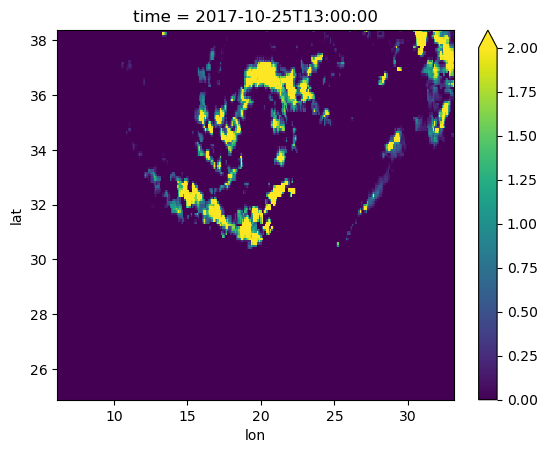

In [94]:
%matplotlib inline

# parameters for plotting
tidx = 3
val_range = {"vmin": 0, "vmax": 2.}

precip_imerg.isel({"time": tidx}).plot(**val_range)

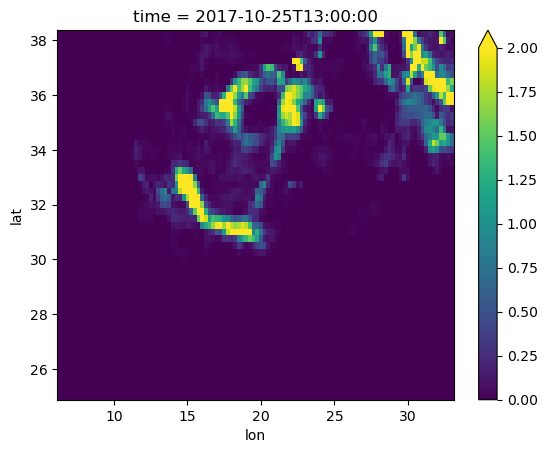

In [95]:
precip_era5.isel({"time": tidx}).plot(**val_range)

# Michael's code to generate data from token information

In [17]:
isample = 3

imerg_sample = (targets[0].numpy())[isample, 0, ...]
era5_sample = (sources[-1].numpy())[isample, 0, ...]

In [18]:
year, day, hour = tuple(token_infos[-1].numpy()[isample, 0, 0, 0][0:3])

date_start = pd.to_datetime(year * 1000 + day, format='%Y%j')
date_start = date_start + pd.to_timedelta(hour, unit='h') - pd.to_timedelta(1, unit='h')
all_dates = pd.date_range(date_start, periods=36, freq="1h")

# sanity check
year, day, hour = tuple(token_infos[-1].numpy()[isample,0,0,-1][0:3])

date_end = pd.to_datetime(year * 1000 + day, format='%Y%j')
date_end = date_end + pd.to_timedelta(hour, unit='h') + pd.to_timedelta(1, unit='h')

assert all_dates[-1] == date_end, "Inconsistent date information retrieved from token info"

In [19]:
date_start, date_end

(Timestamp('2018-12-13 07:00:00'), Timestamp('2018-12-14 18:00:00'))

In [20]:
lat_min, lat_max = token_infos[-1].numpy()[0, 0, 0, 0][[4]], token_infos[-1].numpy()[0, 0, 0, -1][[4]]
lon_min, lon_max = token_infos[-1].numpy()[0, 0, 0, 0][[5]], token_infos[-1].numpy()[0, 0, 0, -1][[5]]

if lon_min > lon_max:
    lon_min -= 360.

lat_range_era5 = [lat_min[0] - 4*0.25, lat_max[0] + 4*.25]
lon_range_era5 = [lon_min[0] - 4*0.25, lon_max[0] + 4*.25]

lat_range_imerg = [lat_range_era5[0] - 0.25/3, lat_range_era5[1] + 0.25/3]
lon_range_imerg = [lon_range_era5[0] - 0.25/3, lon_range_era5[1] + 0.25/3]

In [21]:
lats_era5, lons_era5 = get_latlon_arr(lat_range_era5, lon_range_era5, .25)
lats_imerg, lons_imerg = get_latlon_arr(lat_range_imerg, lon_range_imerg, .25/3)

In [22]:
precip_era5 = xr.DataArray(era5_sample*1000., dims=["time", "lat", "lon"], 
                           coords={"time": all_dates, "lat": math_to_geolats(lats_era5), "lon": lons_era5})

precip_imerg = xr.DataArray(imerg_sample, dims=["time", "lat", "lon"], 
                           coords={"time": all_dates, "lat": math_to_geolats(lats_imerg), "lon": lons_imerg})

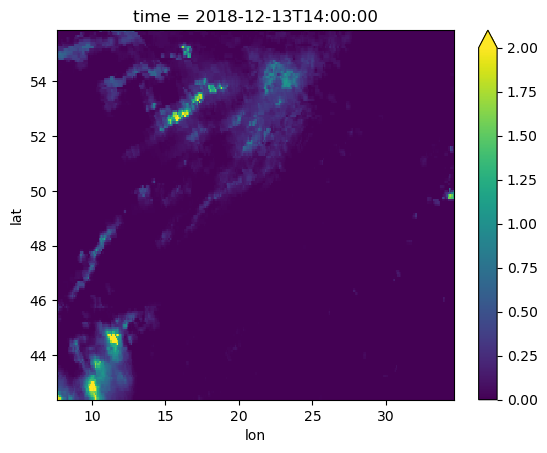

In [36]:
%matplotlib inline

# parameters for plotting
tidx = 7
val_range = {"vmin": 0, "vmax": 2.}

precip_imerg.isel({"time": tidx}).plot(**val_range)

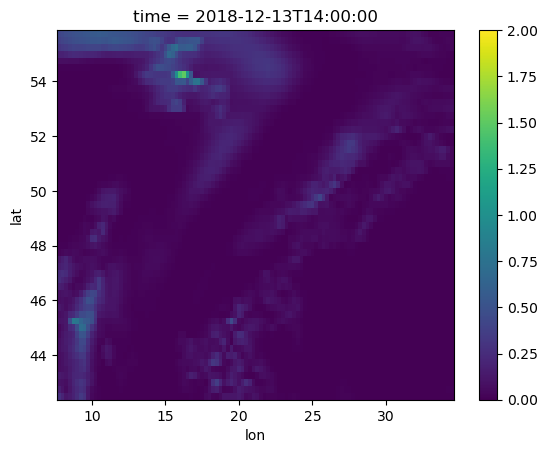

In [37]:
precip_era5.isel({"time": tidx}).plot(**val_range)

# From Ankit's checkpointed files

In [129]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

datadir = Path("/p/project1/deepacf/atmo-rep/patnala1/nc_files_new")
ds_imerg = xr.open_dataset(datadir.joinpath("imerg_25722_44_78.nc"))
ds_era5 = xr.open_dataset(datadir.joinpath("era_5_25722_109_2.nc"))

precip_era5 = ds_era5["total_precip"]
precip_imerg = ds_imerg["total_precip"]

In [130]:
%matplotlib inline

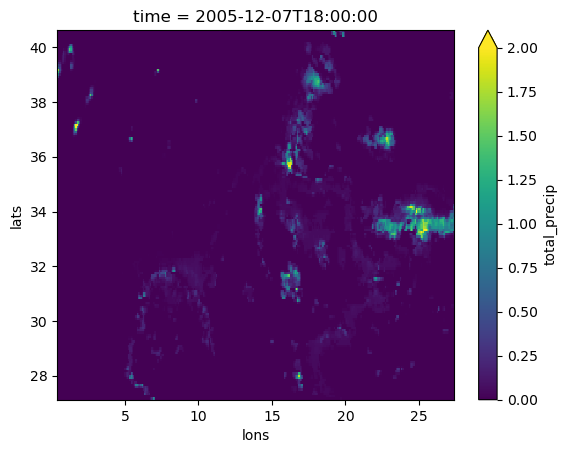

In [131]:
tidx = 0

ds_imerg["total_precip"].isel({"time": tidx}).plot(vmin=0., vmax=2.)

plt.show()

In [132]:
ds_era5["lons"] = ds_era5["lons"].where(ds_era5["lons"] < 180., ds_era5["lons"] - 360.)

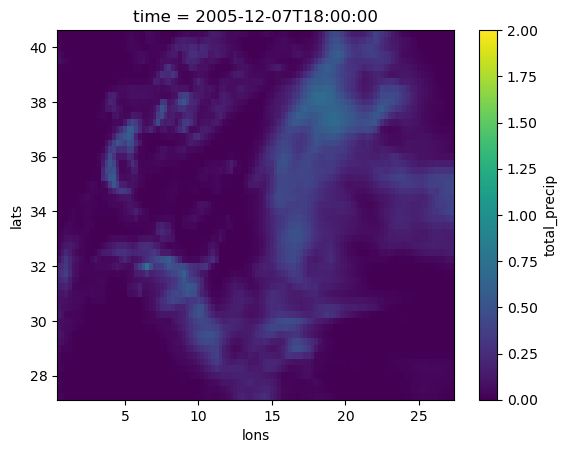

In [133]:
ds_era5["total_precip"].isel({"time": tidx}).plot(vmin=0., vmax=2.)

# Plot data from raw datafiles 

In [96]:
datadir_imerg_raw = Path("/p/scratch/atmo-rep/data/imerg/imerg_regridded")
datadir_era5_raw = Path("/p/scratch/atmo-rep/data/era5/new_structure/total_precip/ml0")

date_now = pd.to_datetime(precip_era5["time"][tidx].values)
ym_str = date_now.strftime("y%Y_m%m")

fname_imerg_raw = datadir_imerg_raw.joinpath(f"3B-HHR.MS.MRG.3IMERG.{ym_str}.nc")
fname_era5_raw = datadir_era5_raw.joinpath(f"era5_total_precip_{ym_str}_ml0.nc")

In [97]:
ds_imerg_raw = xr.open_dataset(fname_imerg_raw)
ds_era5_raw = xr.open_dataset(fname_era5_raw)

In [98]:
#lat_range = (ds_imerg["total_precip"]["lats"].values[0]-.01, ds_imerg["total_precip"]["lats"].values[-1]+.01)
#lon_range = (ds_imerg["total_precip"]["lons"].values[0]-.01, ds_imerg["total_precip"]["lons"].values[-1]+.01)

#precip_imerg_raw = ds_imerg_raw["precipitation"].sel({"lat": slice(*lat_range), "lon": slice(*lon_range), 
#                                                     "time": date_now})
offset = 0

precip_imerg_raw = ds_imerg_raw["precipitation"].sel({"lat": precip_imerg['lat'], "lon": precip_imerg['lon'], 
                                                     "time": date_now + pd.Timedelta(offset,"h")}, method='nearest')
#precip_era5_raw = ds_era5_raw["tp"].sel({"latitude": slice(*lat_range[::-1]), "longitude": slice(*lon_range), 
#                                         "time": date_now})*1000.
precip_era5_raw = ds_era5_raw["tp"].sel({"latitude": precip_era5['lat'], "longitude": precip_era5['lon'], 
                                         "time": date_now + pd.Timedelta(offset,"h")}, method='nearest')*1000.

In [99]:
#precip_era5_raw = precip_era5_raw.reindex({"latitude": precip_era5_raw["latitude"][::-1]})

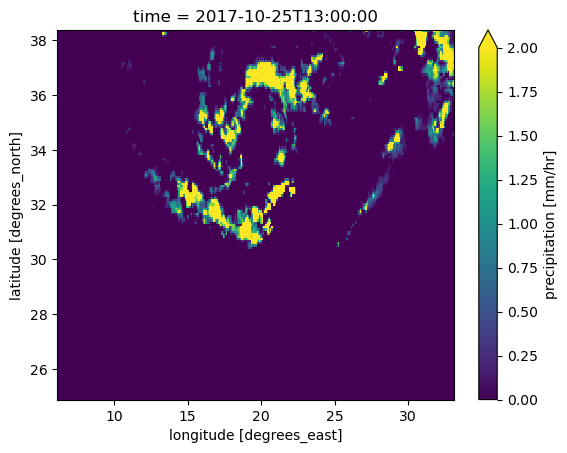

In [100]:
import matplotlib.pyplot as plt
precip_imerg_raw.plot(vmin=0., vmax=2.)

plt.show()

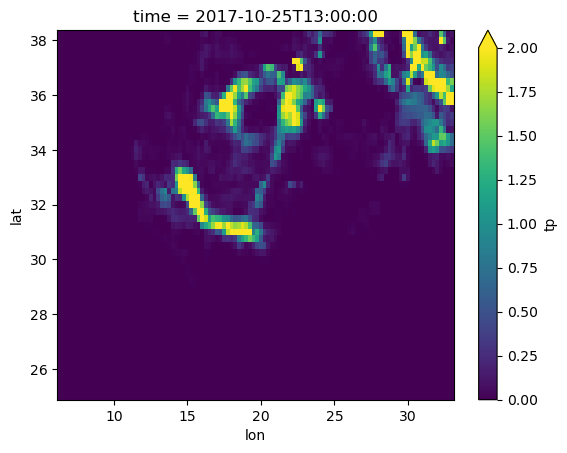

In [101]:
precip_era5_raw.plot(vmin=0., vmax=2.)

plt.show()

In [31]:
ds_imerg_raw

<xarray.Dataset>
Dimensions:        (time: 744, bnds: 2, lon: 651, lat: 594)
Coordinates:
  * time           (time) datetime64[ns] 2018-12-01 ... 2018-12-31T23:00:00
  * lon            (lon) float64 -19.08 -19.0 -18.92 -18.83 ... 34.92 35.0 35.08
  * lat            (lat) float64 24.42 24.5 24.58 24.67 ... 73.67 73.75 73.83
Dimensions without coordinates: bnds
Data variables:
    time_bnds      (time, bnds) datetime64[ns] ...
    precipitation  (time, lat, lon) float32 ...
Attributes:
    CDI:                             Climate Data Interface version 2.0.2 (ht...
    Conventions:                     CF-1.6
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauth...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    NCO:                             netCDF Operators version 5.0.3 (Homepage...
    history:                         Fri Jul 26 10:34:11 2024: cdo -O -s -rem...
    CDO:                             Climate Data Operators version 2.0.2 (ht...

In [138]:
ds_era5_raw

<xarray.Dataset>
Dimensions:    (time: 744, longitude: 241, latitude: 201)
Coordinates:
  * time       (time) datetime64[ns] 2015-03-01 ... 2015-03-31T23:00:00
  * longitude  (longitude) float32 -20.0 -19.75 -19.5 -19.25 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 25.5 25.25 25.0
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.3.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Aug 07 10:40:16 2024: cdo -selname,tp era5_sfc_2015-03....
    CDO:          Climate Data Operators version 2.3.0 (https://mpimet.mpg.de...

In [153]:
lats_era5

array([16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25, 18.5 ,
       18.75, 19.  , 19.25, 19.5 , 19.75, 20.  , 20.25, 20.5 , 20.75,
       21.  , 21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 , 22.75, 23.  ,
       23.25, 23.5 , 23.75, 24.  , 24.25, 24.5 , 24.75, 25.  , 25.25,
       25.5 , 25.75, 26.  , 26.25, 26.5 , 26.75, 27.  , 27.25, 27.5 ,
       27.75, 28.  , 28.25, 28.5 , 28.75, 29.  , 29.25, 29.5 , 29.75])

In [154]:
lons_era5

array([ 5.5 ,  5.75,  6.  ,  6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,
        7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75,
       10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 , 11.75, 12.  ,
       12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75, 14.  , 14.25,
       14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 ,
       16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25, 18.5 , 18.75,
       19.  , 19.25, 19.5 , 19.75, 20.  , 20.25, 20.5 , 20.75, 21.  ,
       21.25, 21.5 , 21.75, 22.  , 22.25, 22.5 , 22.75, 23.  , 23.25,
       23.5 , 23.75, 24.  , 24.25, 24.5 , 24.75, 25.  , 25.25, 25.5 ,
       25.75, 26.  , 26.25, 26.5 , 26.75, 27.  , 27.25, 27.5 , 27.75,
       28.  , 28.25, 28.5 , 28.75, 29.  , 29.25, 29.5 , 29.75, 30.  ,
       30.25, 30.5 , 30.75, 31.  , 31.25, 31.5 , 31.75, 32.  , 32.25])

In [155]:
lats_imerg

array([16.41666667, 16.5       , 16.58333333, 16.66666667, 16.75      ,
       16.83333333, 16.91666667, 17.        , 17.08333333, 17.16666667,
       17.25      , 17.33333333, 17.41666667, 17.5       , 17.58333333,
       17.66666667, 17.75      , 17.83333333, 17.91666667, 18.        ,
       18.08333333, 18.16666667, 18.25      , 18.33333333, 18.41666667,
       18.5       , 18.58333333, 18.66666667, 18.75      , 18.83333333,
       18.91666667, 19.        , 19.08333333, 19.16666667, 19.25      ,
       19.33333333, 19.41666667, 19.5       , 19.58333333, 19.66666667,
       19.75      , 19.83333333, 19.91666667, 20.        , 20.08333333,
       20.16666667, 20.25      , 20.33333333, 20.41666667, 20.5       ,
       20.58333333, 20.66666667, 20.75      , 20.83333333, 20.91666667,
       21.        , 21.08333333, 21.16666667, 21.25      , 21.33333333,
       21.41666667, 21.5       , 21.58333333, 21.66666667, 21.75      ,
       21.83333333, 21.91666667, 22.        , 22.08333333, 22.16

In [156]:
lons_imerg

array([ 5.41666667,  5.5       ,  5.58333333,  5.66666667,  5.75      ,
        5.83333333,  5.91666667,  6.        ,  6.08333333,  6.16666667,
        6.25      ,  6.33333333,  6.41666667,  6.5       ,  6.58333333,
        6.66666667,  6.75      ,  6.83333333,  6.91666667,  7.        ,
        7.08333333,  7.16666667,  7.25      ,  7.33333333,  7.41666667,
        7.5       ,  7.58333333,  7.66666667,  7.75      ,  7.83333333,
        7.91666667,  8.        ,  8.08333333,  8.16666667,  8.25      ,
        8.33333333,  8.41666667,  8.5       ,  8.58333333,  8.66666667,
        8.75      ,  8.83333333,  8.91666667,  9.        ,  9.08333333,
        9.16666667,  9.25      ,  9.33333333,  9.41666667,  9.5       ,
        9.58333333,  9.66666667,  9.75      ,  9.83333333,  9.91666667,
       10.        , 10.08333333, 10.16666667, 10.25      , 10.33333333,
       10.41666667, 10.5       , 10.58333333, 10.66666667, 10.75      ,
       10.83333333, 10.91666667, 11.        , 11.08333333, 11.16